## 4. Representation Analysis Image-Only:

### Imports

In [92]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

### Getting CLIP:

In [93]:
!pip install git+https://github.com/openai/CLIP.git
import clip

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-qref5qpo
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-qref5qpo
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


Device:

In [94]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


CLIP:

In [95]:
model, preprocess = clip.load("ViT-B/32", device=device)

### Loading Fine-tuned ResNet

In [96]:
!wget https://github.com/farazahmad2004/ATML_Assignment_1/raw/main/Saved_Models/resnet_cifar10.pth -O resnet_cifar10.pth

--2025-09-25 11:55:22--  https://github.com/farazahmad2004/ATML_Assignment_1/raw/main/Saved_Models/resnet_cifar10.pth
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/farazahmad2004/ATML_Assignment_1/main/Saved_Models/resnet_cifar10.pth [following]
--2025-09-25 11:55:22--  https://raw.githubusercontent.com/farazahmad2004/ATML_Assignment_1/main/Saved_Models/resnet_cifar10.pth
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94434345 (90M) [application/octet-stream]
Saving to: ‘resnet_cifar10.pth’

resnet_cifar10.pth  100%[===================>]  90.06M   357MB/s    in 0.3s    

2025-09-25 11:55:

In [97]:
import torchvision.models as models
fine_tuned_resnet = models.resnet50(pretrained=False, num_classes=10)
fine_tuned_resnet.load_state_dict(torch.load("resnet_cifar10.pth", map_location=device))
fine_tuned_resnet = fine_tuned_resnet.to(device)
fine_tuned_resnet.eval()

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [98]:
resnet_embedding_model = nn.Sequential(*list(fine_tuned_resnet.children())[:-1])
resnet_embedding_model = resnet_embedding_model.to(device)
resnet_embedding_model.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


### Getting CIFAR-10

In [99]:
transform = transforms.ToTensor()
cifar10_test = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
cifar_classes = cifar10_test.classes
print(cifar_classes)
selected_images = {}
for image, label in cifar10_test:
    class_name = cifar_classes[label]
    if class_name not in selected_images:
        selected_images[class_name] = image
    if len(selected_images) == 10:
        break
print("Selected Classes:", list(selected_images.keys()))

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Selected Classes: ['cat', 'ship', 'airplane', 'frog', 'automobile', 'truck', 'dog', 'horse', 'deer', 'bird']


### Making Sketches of the images:

In [100]:
def convert_to_sketch(img_tensor):
    img = img_tensor.permute(1, 2, 0).numpy()
    img = (img * 255).astype(np.uint8)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    inv = 255 - gray
    blur = cv2.GaussianBlur(inv, (21, 21), 0)
    sketch = cv2.divide(gray, 255 - blur, scale=256)
    return sketch

#### Generate Sketches

In [101]:
sketch_images = {class_name: convert_to_sketch(image) for class_name, image in selected_images.items()}

#### Visualization

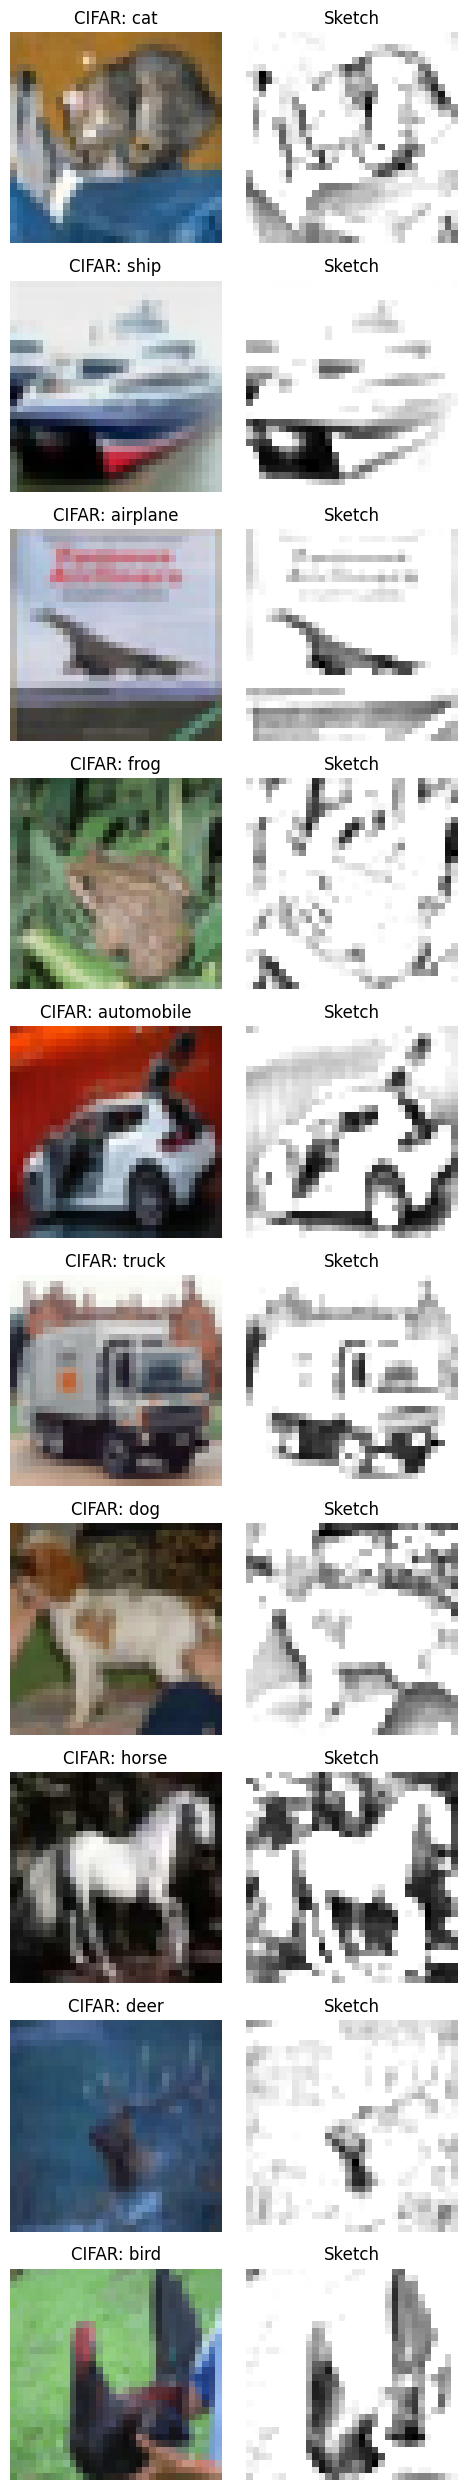

In [102]:
fig, axes = plt.subplots(10, 2, figsize=(5, 25))
for i, class_name in enumerate(selected_images.keys()):
    axes[i, 0].imshow(selected_images[class_name].permute(1, 2, 0))
    axes[i, 0].set_title(f"CIFAR: {class_name}")
    axes[i, 0].axis("off")
    axes[i, 1].imshow(sketch_images[class_name], cmap="gray")
    axes[i, 1].set_title("Sketch")
    axes[i, 1].axis("off")
plt.tight_layout()
plt.show()

Combining

In [108]:
# originals + sketches in one list:
all_images = []
for class_name in selected_images.keys():
    all_images.append((class_name, "cifar", selected_images[class_name]))
    sketch_tensor = torch.tensor(sketch_images[class_name], dtype=torch.float32) / 255.0
    sketch_tensor = sketch_tensor.unsqueeze(0).repeat(3, 1, 1)
    all_images.append((class_name, "sketch", sketch_tensor))
print(f"Total images: {len(all_images)}")

Total images: 20


### Getting Image Embeddings for CLIP and Resnet

In [109]:
# CLIP embeddings
def get_clip_embeddings(all_images, model, preprocess, device):
    embeddings = []
    for class_name, img_type, img_tensor in all_images:
        pil_img = transforms.ToPILImage()(img_tensor)
        input_tensor = preprocess(pil_img).unsqueeze(0).to(device)
        with torch.no_grad():
            emb = model.encode_image(input_tensor)
            emb = emb / (emb.norm(dim=-1, keepdim=True)+1e-10)
            emb = emb.cpu().numpy().flatten()
        embeddings.append((class_name, img_type, emb))
    return embeddings

In [110]:
resnet_transform = transforms.Compose([
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

In [111]:
# ResNet embeddings
def get_resnet_embeddings(all_images, resnet_embedding_model, device, resnet_transform):
    embeddings = []
    for class_name, img_type, img_tensor in all_images:
        input_tensor = resnet_transform(img_tensor).unsqueeze(0).to(device)
        with torch.no_grad():
            emb = resnet_embedding_model(input_tensor)
            emb = torch.flatten(emb, 1)
            emb = emb / (emb.norm(dim=-1, keepdim=True)+1e-10)
            emb = emb.cpu().numpy().flatten()
        embeddings.append((class_name, img_type, emb))
    return embeddings

### Dimensionality Reduction with t-SNE:

Imports

In [112]:
from sklearn.manifold import TSNE

Embeddings

In [113]:
embeddings_clip = get_clip_embeddings(all_images, model, preprocess, device)
embeddings_resnet = get_resnet_embeddings(all_images, resnet_embedding_model, device, resnet_transform=resnet_transform)

Visualization

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


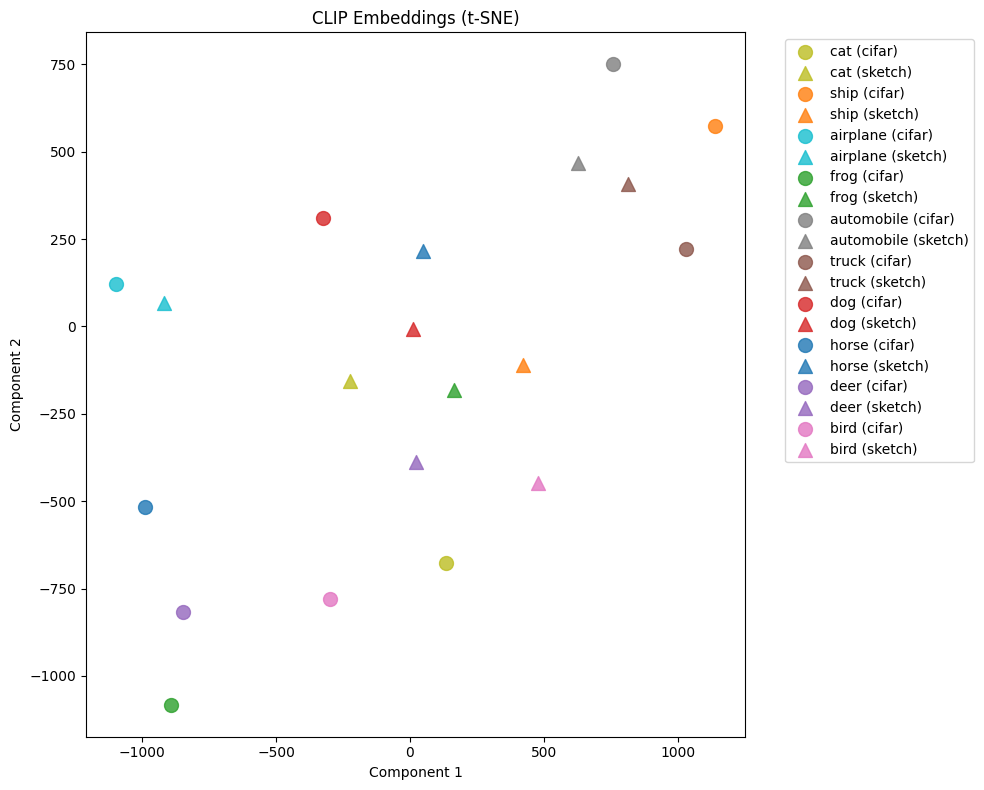

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


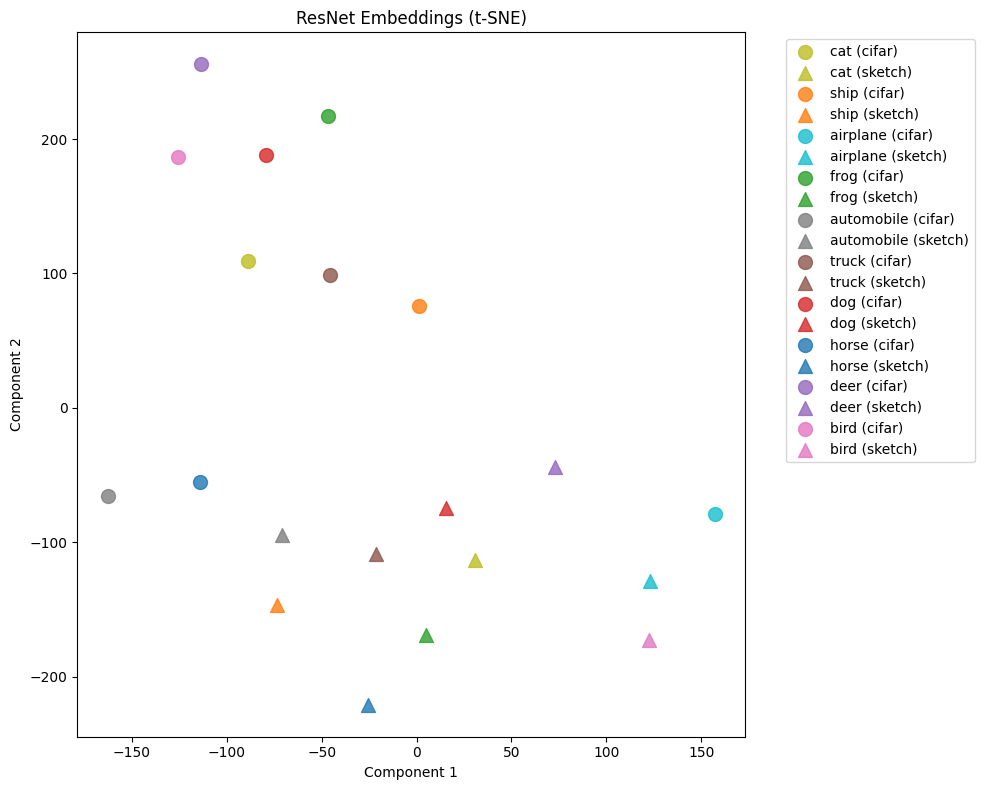

In [117]:
def visualize_embeddings(embeddings, title):
    embs = np.array([e[2] for e in embeddings])
    class_labels = [name for name, _, _ in embeddings]
    domain_labels = [typ for _, typ, _ in embeddings]
    reducer = TSNE(n_components=2, perplexity=5, learning_rate=200.0, n_iter=1000, random_state=42)
    reduced = reducer.fit_transform(embs)
    # Plot: color by class, marker by domain
    fig, ax = plt.subplots(figsize=(10, 8))
    unique_classes = list(set(class_labels))
    class_to_color = {cls: plt.cm.tab10(i / len(unique_classes)) for i, cls in enumerate(unique_classes)}
    # Circle for original, triangle for sketch
    domain_to_marker = {"cifar": "o", "sketch": "^"}
    plotted_labels = set()
    for i in range(len(reduced)):
        cls = class_labels[i]
        dom = domain_labels[i]
        label = f"{cls} ({dom})" if f"{cls}_{dom}" not in plotted_labels else None
        ax.scatter(reduced[i, 0], reduced[i, 1],
                   color=class_to_color[cls],
                   marker=domain_to_marker[dom],
                   s=100, alpha=0.8, label=label)
        plotted_labels.add(f"{cls}_{dom}")
    ax.set_title(title)
    ax.set_xlabel("Component 1")
    ax.set_ylabel("Component 2")
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
# Visualize
visualize_embeddings(embeddings_clip, "CLIP Embeddings (t-SNE)")
visualize_embeddings(embeddings_resnet, "ResNet Embeddings (t-SNE)")